In [3]:
# 03_model_nn.ipynb
# Simple neural network model on the processed UCI diabetes cohort

import sys
import os

repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

print("Repo root:", repo_root)

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

from src.train import split_data

PROCESSED_PATH = "../data_processed/admissions_features.csv"

df = pd.read_csv(PROCESSED_PATH)
print("Raw processed shape:", df.shape)
df.head()

Repo root: /Users/abinayaravi/Downloads/UCI/med-sideeffect-risk
Raw processed shape: (25000, 64)


,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,on_diabetes_med,med_up,med_down,...,diag_3_Respiratory,diag_3_nan,glucose_test_high,glucose_test_no,glucose_test_normal,glucose_test_nan,A1Ctest_high,A1Ctest_no,A1Ctest_normal,A1Ctest_nan
0,8,72,1,18,2,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1,3,34,2,13,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
2,5,45,0,18,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
3,2,36,0,12,1,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,42,0,7,0,0,0,0,0,0,...,True,False,False,True,False,False,False,True,False,False


In [4]:
label_col = "label"
id_cols = ["encounter_id", "patient_nbr"]

# use same splitting function as in 02
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, label_col=label_col)

# drop ID + label columns from features
drop_cols = id_cols + [label_col]
X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns])
X_val   = X_val.drop(columns=[c for c in drop_cols if c in X_val.columns])
X_test  = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])

print("X_train:", X_train.shape)
print("X_val:",   X_val.shape)
print("X_test:",  X_test.shape)

y_train = y_train.values
y_val   = y_val.values
y_test  = y_test.values

print("Positive rate (train):", y_train.mean())

X_train: (17500, 63)
X_val: (3750, 63)
X_test: (3750, 63)
Positive rate (train): 0.4701714285714286


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((17500, 63), (3750, 63), (3750, 63))

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

batch_size = 256

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

Using device: cpu


In [7]:
import torch.nn as nn
import torch.nn.functional as F
from src.models_nn import TabularNN

input_dim = X_train_t.shape[1]
print("Input dim:", input_dim)

model = TabularNN(input_dim).to(device)
model

Input dim: 63


TabularNN(
  (net): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [8]:
# compute pos_weight = (#neg / #pos) for train set
pos = y_train.sum()
neg = len(y_train) - pos
pos_weight_value = neg / max(pos, 1)

pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)
print("pos_weight:", pos_weight.item())

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4,   # L2 regularization
)

pos_weight: 1.126883864402771


In [9]:
def evaluate_nn(model, data_loader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)
    return auroc, auprc, all_probs, all_labels

num_epochs = 200
best_val_auroc = 0.0
best_state = None

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # validation metrics
    val_auroc, val_auprc, _, _ = evaluate_nn(model, val_loader)

    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        best_state = model.state_dict()

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | "
          f"val_AUROC={val_auroc:.4f} | val_AUPRC={val_auprc:.4f}")

# load best model (by val AUROC)
if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model with val AUROC:", best_val_auroc)

Epoch 01 | train_loss=0.7198 | val_AUROC=0.6337 | val_AUPRC=0.6055
Epoch 02 | train_loss=0.7029 | val_AUROC=0.6450 | val_AUPRC=0.6137
Epoch 03 | train_loss=0.6954 | val_AUROC=0.6491 | val_AUPRC=0.6167
Epoch 04 | train_loss=0.6939 | val_AUROC=0.6488 | val_AUPRC=0.6168
Epoch 05 | train_loss=0.6893 | val_AUROC=0.6523 | val_AUPRC=0.6193
Epoch 06 | train_loss=0.6876 | val_AUROC=0.6501 | val_AUPRC=0.6172
Epoch 07 | train_loss=0.6847 | val_AUROC=0.6530 | val_AUPRC=0.6188
Epoch 08 | train_loss=0.6837 | val_AUROC=0.6525 | val_AUPRC=0.6180
Epoch 09 | train_loss=0.6822 | val_AUROC=0.6566 | val_AUPRC=0.6204
Epoch 10 | train_loss=0.6837 | val_AUROC=0.6519 | val_AUPRC=0.6171
Epoch 11 | train_loss=0.6797 | val_AUROC=0.6533 | val_AUPRC=0.6180
Epoch 12 | train_loss=0.6794 | val_AUROC=0.6520 | val_AUPRC=0.6161
Epoch 13 | train_loss=0.6801 | val_AUROC=0.6532 | val_AUPRC=0.6182
Epoch 14 | train_loss=0.6779 | val_AUROC=0.6521 | val_AUPRC=0.6164
Epoch 15 | train_loss=0.6751 | val_AUROC=0.6558 | val_AUPRC=0.

In [10]:
test_auroc, test_auprc, test_probs, test_labels = evaluate_nn(model, test_loader)

print("Final NN performance on TEST set:")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.44f}")

Final NN performance on TEST set:
AUROC: 0.6183
AUPRC: 0.59345922175131793352420572773553431034088135


Accuracy: 0.5890666666666666
Confusion matrix:
 [[1278  709]
 [ 832  931]]


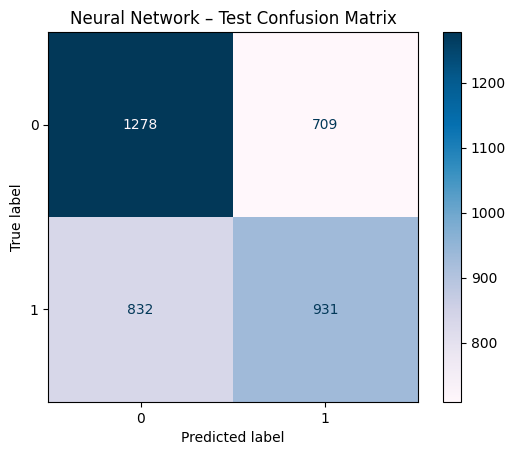

Classification report (test, Neural Network):
               precision    recall  f1-score   support

         0.0      0.606     0.643     0.624      1987
         1.0      0.568     0.528     0.547      1763

    accuracy                          0.589      3750
   macro avg      0.587     0.586     0.586      3750
weighted avg      0.588     0.589     0.588      3750



In [11]:
test_preds = (test_probs >= 0.5).astype(int)
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

acc = accuracy_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)
print("Accuracy:", acc)
print("Confusion matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d", cmap="PuBu")
plt.title("Neural Network – Test Confusion Matrix")
plt.show()
print("Classification report (test, Neural Network):\n", classification_report(test_labels, test_preds, digits=3))

In [12]:
def get_embeddings(model, data_loader, device):
    model.eval()
    all_emb = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            # pass through all layers except the final linear output layer
            h = model.net[:-1](xb)
            all_emb.append(h.cpu().numpy())
            all_labels.append(yb.numpy())
    return np.concatenate(all_emb, axis=0), np.concatenate(all_labels, axis=0)

X_train_emb, y_train_emb = get_embeddings(model, train_loader, device)
X_val_emb,   y_val_emb   = get_embeddings(model, val_loader, device)
X_test_emb,  y_test_emb  = get_embeddings(model, test_loader, device)

emb_train, emb_val, emb_test = X_train_emb, X_val_emb, X_test_emb
y_train,  y_val,  y_test     = y_train_emb, y_val_emb, y_test_emb

np.save("../data_processed/embeddings_train.npy", emb_train)
np.save("../data_processed/embeddings_val.npy",   emb_val)
np.save("../data_processed/embeddings_test.npy",  emb_test)
np.save("../data_processed/y_train.npy",          y_train)
np.save("../data_processed/y_val.npy",            y_val)
np.save("../data_processed/y_test.npy",           y_test)

print("\nFiles in ../data_processed after saving:")
print(os.listdir("../data_processed"))


Files in ../data_processed after saving:
['embeddings_test.npy', 'embeddings_val.npy', 'admissions_features_enhanced.csv', 'y_train.npy', 'embeddings_train.npy', 'y_test.npy', 'y_val.npy', 'admissions_features.csv']


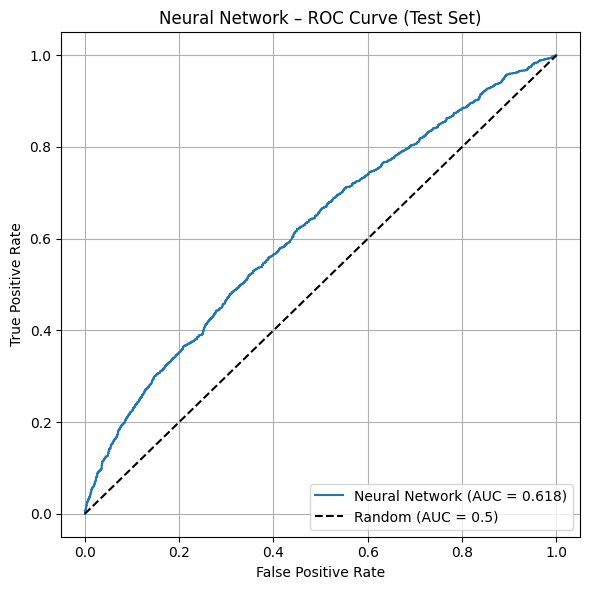

In [13]:
from sklearn.metrics import roc_curve, RocCurveDisplay

# Make sure probs are 1D
probs_1d = test_probs.ravel()

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(test_labels, probs_1d)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {test_auroc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Network – ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()